In [1]:
DATA_DIR = '../../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [2]:
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cross_decomposition import PLSRegression, CCA
import joblib
import matplotlib.pyplot as plt

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.

In [12]:
if False: # to be done once only
    
    # Create/store/load binary image data
    if not os.path.isfile(DATA_DIR + 'binary_imgs.npy'):

        dataset_path = "../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
        img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
        img_filenames.sort()
        print('Number of subjects: %d' % len(img_filenames))

        img_shape = load_img(img_filenames[0]).shape

        mask_img = load_mni152_brain_mask()
        masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
        masker = masker.fit()

        imgs = masker.transform(img_filenames) # break down into slices if necessary
        imgs = imgs.astype(bool)
        np.save(DATA_DIR + 'binary_imgs', imgs)

    else:
        imgs = np.load(DATA_DIR + 'binary_imgs.npy')

    imgs.shape

## Multitask analysis with 100 PC components

In [13]:
# Calculate 100 PC components
if not os.path.isfile(DATA_DIR + 'binary_imgs_pc_100.npy'):    
    pca = PCA(n_components=100, copy=False)
    X_pc = pca.fit_transform(imgs)
    np.save(DATA_DIR + 'binary_imgs_pc_100.npy', X_pc)
    
else:
    X_pc = np.load(DATA_DIR + 'binary_imgs_pc_100.npy')
    
X_pc.shape

(1401, 100)

In [14]:
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


In [95]:
## common library

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(39)

def mixup_data(X, Y, alpha=0.1, mul_factor=10):
    
    rs = np.random.RandomState(39)
    n = X.shape[0]
    
    mixed_X = np.empty((n*(mul_factor-1), X.shape[1]))
    mixed_Y = np.empty((n*(mul_factor-1), Y.shape[1]))
    
    for i in range(mul_factor-1):
        
        # sample more than needed as some will be filtered out
        lam = np.random.beta(alpha, alpha, size=round(n*1.2))
        
        # original data vectors will be concatenated later
        lam = lam[(lam!=0.0) & (lam!=1.0)][:n][:, None]
        
        shuffle_idx = rs.choice(np.arange(n), n, replace=False)

        mixed_X[i*n : (i+1)*n] = lam * X + (1 - lam) * X[shuffle_idx, :]
        mixed_Y[i*n : (i+1)*n] = lam * Y + (1 - lam) * Y[shuffle_idx, :]
        
    # concatenate original data vectors
    mixed_X = np.append(mixed_X, X, axis=0)
    mixed_Y = np.append(mixed_Y, Y, axis=0)
            
    return mixed_X, mixed_Y


SCORE_DOMAINS = ['Global Cognition', 'Language', 'Visuospatial Functioning', 'Memory',\
                 'Information Processing Speed', 'Executive Functioning']

def calculate_regression_metrics(est_cv, X_train, X_test, y_train, y_test, model_name, i_fold, score_domain=None):
    
    scores = []
    
    y_predicted_train = est_cv.predict(X_train)
    y_predicted_test = est_cv.predict(X_test)
        
    train_rsq = r2_score(y_train, y_predicted_train, multioutput='raw_values')
    test_rsq = r2_score(y_test, y_predicted_test, multioutput='raw_values')        

    train_mae = mean_absolute_error(y_train, y_predicted_train, multioutput='raw_values')
    test_mae = mean_absolute_error(y_test, y_predicted_test, multioutput='raw_values')
    
    if score_domain is None: # multioutput model
        
        for i in range(len(SCORE_DOMAINS)):
            scores.append([model_name, SCORE_DOMAINS[i], "R2", "In-sample", i_fold, train_rsq[i]])
            scores.append([model_name, SCORE_DOMAINS[i], "R2", "Out-of-sample", i_fold, test_rsq[i]])
            scores.append([model_name, SCORE_DOMAINS[i], "MAE", "In-sample", i_fold, train_mae[i]])
            scores.append([model_name, SCORE_DOMAINS[i], "MAE", "Out-of-sample", i_fold, test_mae[i]])
        
    else:

        scores.append([model_name, score_domain, "R2", "In-sample", i_fold, train_rsq])
        scores.append([model_name, score_domain, "R2", "Out-of-sample", i_fold, test_rsq])
        scores.append([model_name, score_domain, "MAE", "In-sample", i_fold, train_mae])
        scores.append([model_name, score_domain, "MAE", "Out-of-sample", i_fold, test_mae])
    
    return scores
    
    
def run_regression(X, Y, estimator, grid, model_name, random_search_cv=False, n_jobs=-1, random_iter=20, 
                   pca_fold=False, nn=False, callbacks=None, print_best_params=True, 
                   multioutput=False, mixup=False, mixup_alpha=0.1, mixup_mul_factor=10):

    scores = []
    best_params = []

    kfold_outer = KFold(n_splits=5, shuffle=True, random_state=39)

    i_fold = 1

    for train, test in kfold_outer.split(X):

        X_train = X[train]
        X_test = X[test]
        
        if pca_fold:
            pca = PCA(n_components=100)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        
        Y_train = Y[train]
        Y_test = Y[test]        
                

        if mixup:
            X_train, Y_train = mixup_data(X_train, Y_train, alpha=mixup_alpha, mul_factor=mixup_mul_factor)

        kfold_inner = KFold(n_splits=5)

        if random_search_cv:
            est_cv = RandomizedSearchCV(estimator=estimator, param_distributions=grid, n_jobs=n_jobs,
                                        cv=kfold_inner, random_state=39, n_iter=random_iter)
        else:
            est_cv = GridSearchCV(estimator=estimator, param_grid=grid, n_jobs=n_jobs,
                                  cv=kfold_inner)


        print('\nFold-' + str(i_fold) + '\n')
        
        if multioutput:
            
            if nn:
                est_cv.fit(X_train, Y_train, nn=True, callbacks=callbacks)

            else:
                est_cv.fit(X_train, Y_train)

            scores_fold = calculate_regression_metrics(est_cv, X_train, X_test, Y_train, Y_test, 
                                                       model_name, i_fold)

            scores.extend(scores_fold)

            best_params.append([model_name, i_fold, est_cv.best_params_])
            
            if print_best_params:
                print("Best params:", best_params[-1])
            
            
        else: # single output models            
            
            for i_domain in range(Y.shape[1]):
                
                print(SCORE_DOMAINS[i_domain])
                
                y_train = Y_train[:, i_domain]
                y_test = Y_test[:, i_domain]
            

                if nn:
                    est_cv.fit(X_train, y_train, nn=True, callbacks=callbacks)

                else:
                    est_cv.fit(X_train, y_train)

                scores_fold = calculate_regression_metrics(est_cv, X_train, X_test, y_train, Y_test, 
                                                           model_name, i_fold, SCORE_DOMAINS[i_domain])

                scores.extend(scores_fold)

                best_params.append([model_name, SCORE_DOMAINS[i_domain], i_fold, est_cv.best_params_])
                
                if print_best_params:
                    print("Best params:", best_params[-1])
        

        i_fold += 1


    scores_df = pd.DataFrame(scores, columns=["Model", "Domain", "Metric", "Score type", "Fold", "Score"])    
    best_params_df = pd.DataFrame(best_params)
    
    if mixup:
        scores_df.insert(0, "\u03B1", mixup_alpha) # alpha symbol
        scores_df.insert(0, "Data mul factor", str(mixup_mul_factor)+"x")
    else:
        scores_df.insert(0, "\u03B1", "No mixup") # alpha symbol
        scores_df.insert(0, "Data mul factor", "No mixup") # alpha symbol    
    
    return scores_df, best_params_df


In [148]:
def plot_scores(score_df, title=None, hue_order=None):
    
    g = sns.catplot(x="Domain", y="Score", hue="\u03B1", col="Data mul factor", 
                    data=score_df, ci="sd", kind="bar", hue_order=hue_order,
                   col_order=["No mixup", "5x", "10x", "50x"])

    g.set_axis_labels("", "Score (Mean and Standard Deviation across 5 CV folds)")

    for i, ax in enumerate(g.fig.axes):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
        ax.axhline(0, color="black")

    g.fig.suptitle(title, y=1.08, fontsize=30)
    plt.savefig("results/" + title, bbox_inches="tight")
    plt.show()

def plot_all_scores(score_df, hue_order=None):
    
    for metric in score_df["Metric"].unique():
        
        for score_type in score_df["Score type"].unique():
            
            filtered_data = score_df[(score_df["Metric"]==metric) & (score_df["Score type"]==score_type)]
            
            title = "Regression - Multitask Ridge - " + metric + " - " + score_type
            
            plot_scores(filtered_data, title, hue_order=hue_order)
    

### Multitask Ridge - Mixup

In [128]:
def multitask_ridge(X, Y, alpha, mixup=True, mixup_alpha=None, mixup_mul_factor=None):
    
    estimator = MultiTaskElasticNet(l1_ratio=0.001, max_iter=10000)
    grid={"alpha": alpha}

    return run_regression(X, Y, estimator, grid, "Multitask Ridge", multioutput=True, 
                          mixup=mixup, mixup_alpha=mixup_alpha, mixup_mul_factor=mixup_mul_factor)

In [94]:
# first get results with no mixup
ridge_alpha = np.linspace(0, 50, 51)
scores_mr_no_mixup, best_params_mr_no_mixup = multitask_ridge(X_pc, Y, ridge_alpha, mixup=False)


Fold-1:

Best params: ['Multitask Ridge', 1, {'alpha': 36.0}]

Fold-2:

Best params: ['Multitask Ridge', 2, {'alpha': 39.0}]

Fold-3:

Best params: ['Multitask Ridge', 3, {'alpha': 25.0}]

Fold-4:

Best params: ['Multitask Ridge', 4, {'alpha': 37.0}]

Fold-5:

Best params: ['Multitask Ridge', 5, {'alpha': 30.0}]


In [145]:

scores_mr_all = pd.DataFrame()
best_params_mr_all = pd.DataFrame()

scores_mr_all = pd.concat([scores_mr_all, scores_mr_no_mixup], ignore_index=True)
best_params_mr_all = pd.concat([best_params_mr_all, best_params_mr_no_mixup], ignore_index=True)

In [80]:
# with mixup
# 10x

mixup_alphas = [0.1, 0.2, 0.3]
mixup_mul_factors = [10]

ridge_alpha = [0.001, 0.006, 0.008, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.15, 0.2, 5]

for mixup_mul_factor in mixup_mul_factors:
    
    for mixup_alpha in mixup_alphas:
        
        print("\n\nData mul factor:", str(mixup_mul_factor)+"x,", "Mixup alpha:", mixup_alpha)

        scores_mr, best_params_mr = multitask_ridge(X_pc, Y, ridge_alpha, mixup=True, mixup_alpha=mixup_alpha, mixup_mul_factor=mixup_mul_factor)

        scores_mr_all = pd.concat([scores_mr_all, scores_mr], ignore_index=True)
        best_params_mr_all = pd.concat([best_params_mr_all, best_params_mr], ignore_index=True)




Data mul factor: 10x, Mixup alpha: 0.1

Fold-1:

Best params: ['Multitask Ridge', 1, {'alpha': 0.04}]

Fold-2:

Best params: ['Multitask Ridge', 2, {'alpha': 0.08}]

Fold-3:

Best params: ['Multitask Ridge', 3, {'alpha': 0.04}]

Fold-4:

Best params: ['Multitask Ridge', 4, {'alpha': 0.04}]

Fold-5:

Best params: ['Multitask Ridge', 5, {'alpha': 0.02}]


Data mul factor: 10x, Mixup alpha: 0.2

Fold-1:

Best params: ['Multitask Ridge', 1, {'alpha': 0.04}]

Fold-2:

Best params: ['Multitask Ridge', 2, {'alpha': 0.04}]

Fold-3:

Best params: ['Multitask Ridge', 3, {'alpha': 0.04}]

Fold-4:

Best params: ['Multitask Ridge', 4, {'alpha': 0.04}]

Fold-5:

Best params: ['Multitask Ridge', 5, {'alpha': 0.02}]


Data mul factor: 10x, Mixup alpha: 0.3

Fold-1:

Best params: ['Multitask Ridge', 1, {'alpha': 0.02}]

Fold-2:

Best params: ['Multitask Ridge', 2, {'alpha': 0.04}]

Fold-3:

Best params: ['Multitask Ridge', 3, {'alpha': 0.04}]

Fold-4:

Best params: ['Multitask Ridge', 4, {'alpha': 0.



Data mul factor: 10x, Mixup alpha: 1.0

Fold-1:

Best params: ['Multitask Ridge', 1, {'alpha': 0.02}]

Fold-2:

Best params: ['Multitask Ridge', 2, {'alpha': 0.02}]

Fold-3:

Best params: ['Multitask Ridge', 3, {'alpha': 0.04}]

Fold-4:

Best params: ['Multitask Ridge', 4, {'alpha': 0.04}]

Fold-5:

Best params: ['Multitask Ridge', 5, {'alpha': 0.01}]


In [139]:
# 5x

mixup_alphas = [0.1, 0.2, 0.3, 1.0]
mixup_mul_factors = [5]

# ridge_alpha = [0.006, 0.008, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.2, 5]
ridge_alpha = [0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.3, 5]

for mixup_mul_factor in mixup_mul_factors:
    
    for mixup_alpha in mixup_alphas:
        
        print("\n\nData mul factor:", str(mixup_mul_factor)+"x,", "Mixup alpha:", mixup_alpha)

        scores_mr, best_params_mr = multitask_ridge(X_pc, Y, ridge_alpha, mixup=True, mixup_alpha=mixup_alpha, mixup_mul_factor=mixup_mul_factor)
        
        scores_mr_all = pd.concat([scores_mr_all, scores_mr], ignore_index=True)
        best_params_mr_all = pd.concat([best_params_mr_all, best_params_mr], ignore_index=True)




Data mul factor: 5x, Mixup alpha: 0.1

Fold-1

Best params: ['Multitask Ridge', 1, {'alpha': 0.08}]

Fold-2

Best params: ['Multitask Ridge', 2, {'alpha': 0.1}]

Fold-3

Best params: ['Multitask Ridge', 3, {'alpha': 0.12}]

Fold-4

Best params: ['Multitask Ridge', 4, {'alpha': 0.08}]

Fold-5

Best params: ['Multitask Ridge', 5, {'alpha': 0.06}]


Data mul factor: 5x, Mixup alpha: 0.2

Fold-1

Best params: ['Multitask Ridge', 1, {'alpha': 0.06}]

Fold-2

Best params: ['Multitask Ridge', 2, {'alpha': 0.12}]

Fold-3

Best params: ['Multitask Ridge', 3, {'alpha': 0.16}]

Fold-4

Best params: ['Multitask Ridge', 4, {'alpha': 0.16}]

Fold-5

Best params: ['Multitask Ridge', 5, {'alpha': 0.06}]


Data mul factor: 5x, Mixup alpha: 0.3

Fold-1

Best params: ['Multitask Ridge', 1, {'alpha': 0.06}]

Fold-2

Best params: ['Multitask Ridge', 2, {'alpha': 0.1}]

Fold-3

Best params: ['Multitask Ridge', 3, {'alpha': 0.08}]

Fold-4

Best params: ['Multitask Ridge', 4, {'alpha': 0.08}]

Fold-5

Best 

In [144]:
# 50x

mixup_alphas = [0.1, 0.2, 0.3, 1.0]
mixup_mul_factors = [50]

ridge_alpha = [0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 5]

for mixup_mul_factor in mixup_mul_factors:
    
    for mixup_alpha in mixup_alphas:
        
        print("\n\nData mul factor:", str(mixup_mul_factor)+"x,", "Mixup alpha:", mixup_alpha)

        scores_mr, best_params_mr = multitask_ridge(X_pc, Y, ridge_alpha, mixup=True, mixup_alpha=mixup_alpha, mixup_mul_factor=mixup_mul_factor)

        scores_mr_all = pd.concat([scores_mr_all, scores_mr], ignore_index=True)
        best_params_mr_all = pd.concat([best_params_mr_all, best_params_mr], ignore_index=True)



Data mul factor: 50x, Mixup alpha: 0.1

Fold-1

Best params: ['Multitask Ridge', 1, {'alpha': 0.006}]

Fold-2

Best params: ['Multitask Ridge', 2, {'alpha': 0.006}]

Fold-3

Best params: ['Multitask Ridge', 3, {'alpha': 0.008}]

Fold-4

Best params: ['Multitask Ridge', 4, {'alpha': 0.008}]

Fold-5

Best params: ['Multitask Ridge', 5, {'alpha': 0.004}]


Data mul factor: 50x, Mixup alpha: 0.2

Fold-1

Best params: ['Multitask Ridge', 1, {'alpha': 0.006}]

Fold-2

Best params: ['Multitask Ridge', 2, {'alpha': 0.008}]

Fold-3

Best params: ['Multitask Ridge', 3, {'alpha': 0.01}]

Fold-4

Best params: ['Multitask Ridge', 4, {'alpha': 0.008}]

Fold-5

Best params: ['Multitask Ridge', 5, {'alpha': 0.002}]


Data mul factor: 50x, Mixup alpha: 0.3

Fold-1

Best params: ['Multitask Ridge', 1, {'alpha': 0.004}]

Fold-2

Best params: ['Multitask Ridge', 2, {'alpha': 0.008}]

Fold-3

Best params: ['Multitask Ridge', 3, {'alpha': 0.008}]

Fold-4

Best params: ['Multitask Ridge', 4, {'alpha': 0.00

In [146]:
# persist/load results
scores_mr_all.to_hdf('results/results_pca_100_multioutput_mixup_mr.h5', key='p', mode='w')
# scores_mr_all = pd.read_hdf('results/results_pca_100_multioutput_mixup_mr.h5', key='p', mode='r')

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:2368: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['Data mul factor', 'α', 'Model', 'Domain', 'Metric', 'Score type']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


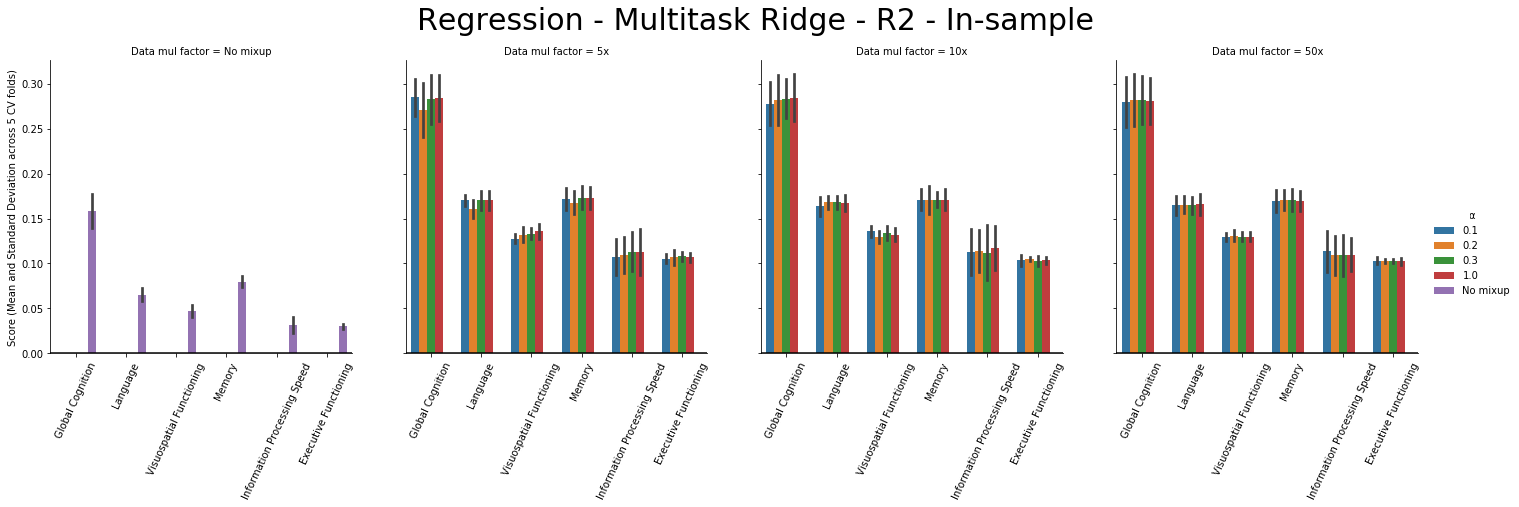

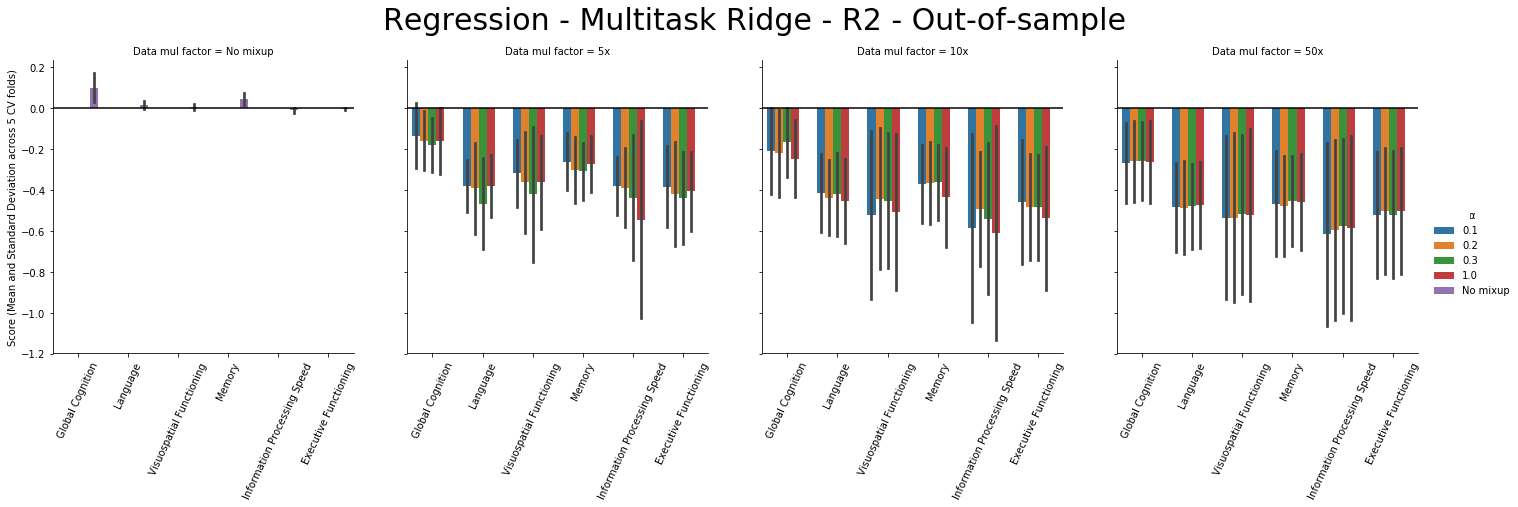

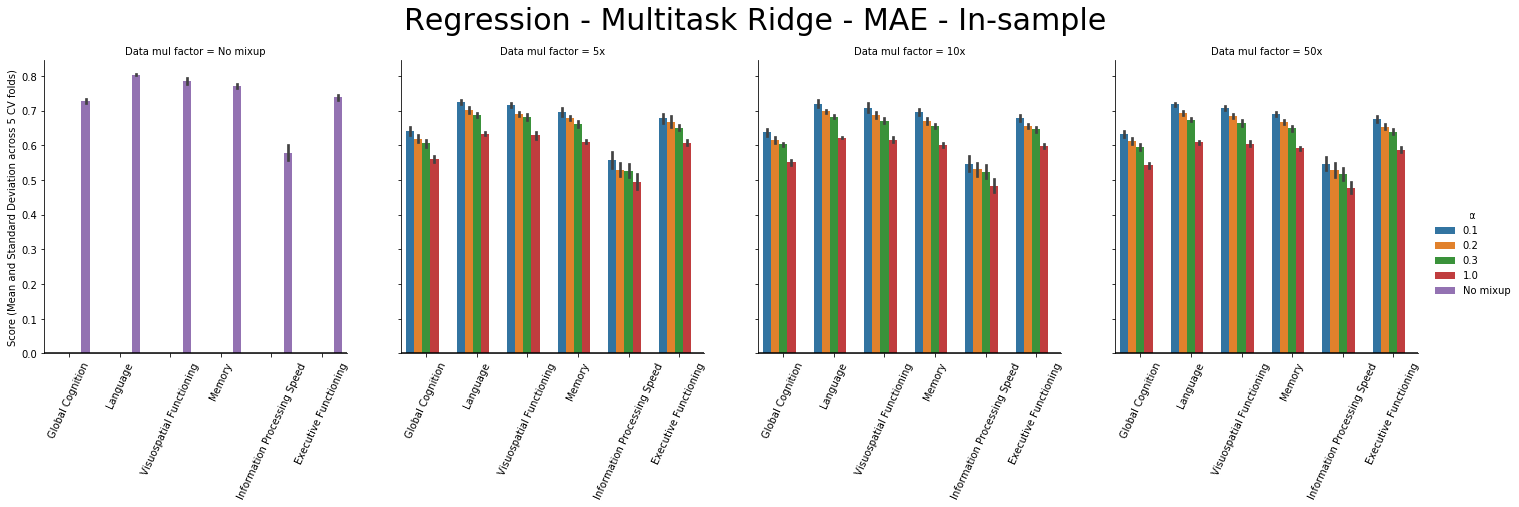

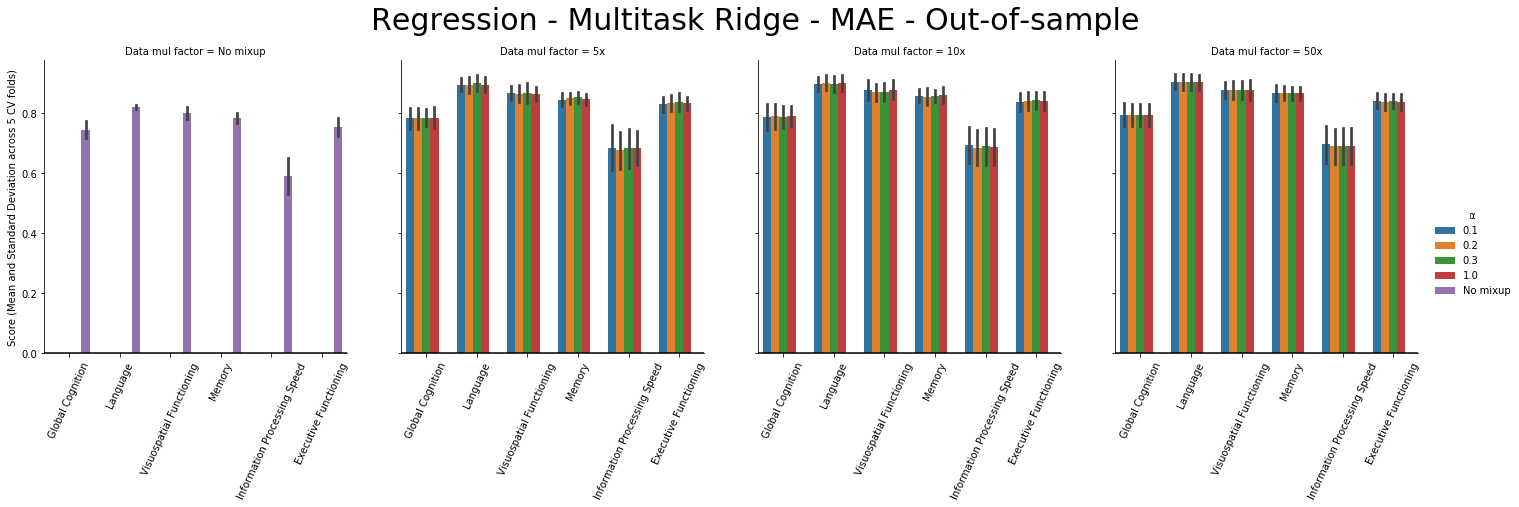

In [149]:
plot_all_scores(scores_mr_all)